# Assignment 6
#### Problem 2

Jérémie Engler and Laure Toullier

07.12.2023

Aim : analysis of a cantilever beam-column element subjected to a tip force

In [3]:
#imports

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

np.set_printoptions(precision=6, suppress=True, linewidth=150)

Params = plt.rcParams
Params['figure.figsize'] = (14, 7) 

In [4]:
#Data

a = 200 #mm
b = 200 #mm
L = 2000 #mm (uniform XS)
E = 200000 #MPa (elastic material)
nf = 10 #number of fibers in the XS
ng=5
stress_fibers = np.ones((ng, nf)) #initial stress in each fiber

Step 1 : Implement and validate a displacement based fiber beam-column element

In [5]:
#computation of tangent section stiffness matrix and section resisting force

def ks(nf):
    yk=np.zeros((nf))     #array for each the coordinate of each centroïd of each fiber
    lk=np.zeros((nf,2))
    ksi=np.zeros((2,2))   #tangent section stiffness matrix
    for i in range(nf):
        yk[i]=-b/2+b/(2*nf)+b/nf*((i+1)-1) #centroïd of each fiber
        lki=np.array([[1,yk[i]]])
        lk[i]=lki
        ksi+=np.transpose(lki)@lki*E*(a*b/nf)
    return ksi

#note: as the XS is constant, ks is constant along the cantilever


def fs(nf, stress_fibers):
    yk=np.zeros((nf))     #array for each the coordinate of each centroïd of each fiber
    lk=np.zeros((nf,2))
    fs=np.zeros((2,ng))   #section resisting force

    for j in range(ng):
        for i in range(nf):
            yk[i]=-b/2+b/(2*nf)+b/nf*((i+1)-1) #centroïd of each fiber
            lki=np.array([[1,yk[i]]])
            lk[i]=lki
            fs[:,j] += + (np.transpose(lki)*stress_fibers[j, i]*(a*b/nf)).reshape(fs[:,j].shape)
    return fs


#note: initially, the stresses are contant in the cantilever, therefore fs is constant

The numerical integration used to obtain a numerical estimate of the integral is Gauss-Lobato, with 5 integration points. The conditions that satisfy all error partial derivatives for 5 integration points are:

    w1=w5=1/10 and r1=1, r5=-1

    w2=w4=49/90 and r2=-sqrt(21)/7, r4=sqrt(21)/7 
    
    w3=32/45 and r3=0

In [6]:
#computation of the stiffness matrix

w=np.array([0.1,49/90,32/45,49/90,0.1])
r=np.array([-1,-np.sqrt(21)/7,0,np.sqrt(21)/7,1])

def Ke_Qe(L,r,w,k_s,f_s):
    
    Ke=np.zeros((6,6))
    Qfv=np.zeros((6,1))

    for i in range(len(w)) :
        xi=L/2*r[i]+L/2

        B=np.array([[-1/L, 0,0,1/L,0,0],
                    [0,(12*xi/L**3-6/L**2), (6*xi/L**2-4/L), 0,(-12*xi/L**3+6/L**2), (6*xi/L**2-2/L)]])
        
        kb=(B.T@k_s)@B
        Ke+=L/2*w[i]*kb

        qb=B.T@f_s[:,i]
        Qfv+=(L/2*qb*w[i]).reshape(Qfv.shape)
    
    return Ke, Qfv




In [7]:
k_s=ks(nf)
f_s=fs(nf, stress_fibers)
K_e,Q_e=Ke_Qe(L,r,w,k_s,f_s)


In [8]:
print(f"k_s={k_s}")
print(f"f_s={f_s}")
print(f"The element resisting force vector is ")
print(Q_e)
print("The tangent element stiffness matrix of a displacement based fiber BC elemnt is:")
print(K_e)

k_s=[[8.00e+09 0.00e+00]
 [0.00e+00 2.64e+13]]
f_s=[[40000. 40000. 40000. 40000. 40000.]
 [    0.     0.     0.     0.     0.]]
The element resisting force vector is 
[[-40000.]
 [     0.]
 [     0.]
 [ 40000.]
 [     0.]
 [     0.]]
The tangent element stiffness matrix of a displacement based fiber BC elemnt is:
[[ 4.00e+06  0.00e+00  0.00e+00 -4.00e+06  0.00e+00  0.00e+00]
 [ 0.00e+00  3.96e+04  3.96e+07  0.00e+00 -3.96e+04  3.96e+07]
 [ 0.00e+00  3.96e+07  5.28e+10  0.00e+00 -3.96e+07  2.64e+10]
 [-4.00e+06  0.00e+00  0.00e+00  4.00e+06  0.00e+00  0.00e+00]
 [ 0.00e+00 -3.96e+04 -3.96e+07  0.00e+00  3.96e+04 -3.96e+07]
 [ 0.00e+00  3.96e+07  2.64e+10  0.00e+00 -3.96e+07  5.28e+10]]


In [9]:
#classical stiffness matrix (from week 7, slide 19)

def stiffness_elastic_beam (E,a,b,L):

    K=np.zeros((6,6))

    I=a*b**3/12
    A=a*b
    
    K[0,0]=E*A/L
    K[0,3]=-E*A/L
    K[3,0]=-E*A/L
    K[3,3]=E*A/L

    K[1,1]=K[4,4]=E*I*12/L**3
    K[1,2]=K[2,1]=E*I*6/L**2
    K[2,2]=K[5,5]=E*I*4/L
    K[5,4]=K[4,5]=-6*E*I/L**2

    K[1,4]=K[4,1]=-E*I*12/L**3
    K[1,5]=K[5,1]=E*I*6/L**2
    K[2,4]=K[4,2]=-E*I*6/L**2
    K[2,5]=K[5,2]=E*I*2/L

    return K

K_classic=stiffness_elastic_beam (E,a,b,L)
print(f"K_classic={K_classic}")


K_classic=[[ 4.000000e+06  0.000000e+00  0.000000e+00 -4.000000e+06  0.000000e+00  0.000000e+00]
 [ 0.000000e+00  4.000000e+04  4.000000e+07  0.000000e+00 -4.000000e+04  4.000000e+07]
 [ 0.000000e+00  4.000000e+07  5.333333e+10  0.000000e+00 -4.000000e+07  2.666667e+10]
 [-4.000000e+06  0.000000e+00  0.000000e+00  4.000000e+06  0.000000e+00  0.000000e+00]
 [ 0.000000e+00 -4.000000e+04 -4.000000e+07  0.000000e+00  4.000000e+04 -4.000000e+07]
 [ 0.000000e+00  4.000000e+07  2.666667e+10  0.000000e+00 -4.000000e+07  5.333333e+10]]


In [10]:
#computation of the error

def error(nf):
    #stress_fibers = np.ones((ng, nf))
    k_s=ks(nf)
    f_s=fs(nf, stress_fibers)
    K_e,Q=Ke_Qe(L,r,w,k_s,f_s)
    
    err=np.linalg.norm(K_e-K_classic)/np.linalg.norm(K_classic)*100
    return err

def error_min(err_accept):
    n_iter=20
    n=1
    while error(n)>err_accept and n<n_iter:
        n+=1
    return n


In [11]:
err=error(nf)
print(f"error={err}")
min_num_fibers=error_min(2)
err_min=error(min_num_fibers)
print(f"Minimum number of fibers for error less than 2%={min_num_fibers}")
print(f"For a minimum number of fiber less than 2%, the error is: {err_min}")

error=0.9999999955000101
Minimum number of fibers for error less than 2%=8
For a minimum number of fiber less than 2%, the error is: 1.5624999929687748


Step 2: Conduct a load control analysis with your beam-column element

Aim: create a cantilever model using displacement-based fiber beam-column element.

In [12]:
nf=min_num_fibers #8 according to step 1
V_end=450000
q0=np.transpose(np.array([[0,0,0,0,0,0]]))         #displacement (initial)
Q_ext=np.transpose(np.array([[0,0,0,0,V_end,0]]))
dof=np.array([3,4,5]) #index at which the element is free
fixed=np.array([0,1,2]) #index at which the element is fixed
num_incr=30    #number of increments
tol=10**(-8)
max_iter=16
iteration_counter=1
stress_fibers=np.zeros((ng, nf)) #new stress in each fiber for new number of fibers
print(f"{stress_fibers.shape = }")


stress_fibers.shape = (5, 8)


In [13]:
#section deformation

def section_deformation(L,q,r):
    ds=np.zeros((2,len(r)))
    for i in range(len(r)):
        xi=L/2*r[i]+L/2
        B=np.array([[-1/L, 0,0,1/L,0,0],
                    [0,(12*xi/L**3-6/L**2), (6*xi/L**2-4/L), 0,(-12*xi/L**3+6/L**2), (6*xi/L**2-2/L)]]) 
        
        dsi=np.matmul(B,q)
        ds[0,i]=dsi[0]
        ds[1,i]=dsi[1]
    print(f"{ds = }")
    return ds

In [14]:
#displacement increment

def displacement_incr(K_ff,R_f):
    deltaqf=np.linalg.solve(K_ff,R_f)
    delta_q_f=np.zeros((6,1))
    for i in range(3):
        delta_q_f[i+3][0]=deltaqf[i][0]
    
    return delta_q_f

In [15]:
#fiber strain
def fiber_strains(nf,b,ds):
    yk=np.zeros((nf))
    eps=np.zeros((len(r), nf))
    for j in range(len(r)):
        for i in range(nf):
            yk[i]=-b/2+b/(2*nf)+b/nf*((i+1)-1) #centroïd of each fiber
            eps[j,i]=ds[0,j]+ds[1,j]*yk[i]
    print(f"{eps =}")
    return eps


#initialisation
force5=[]
disp5=[]
iteration_counter=[0]
q=q0

k_s=ks(nf)
print(f"{nf, stress_fibers.shape = }")
f_s=fs(nf, stress_fibers)
K_e, Q_e= Ke_Qe(L,r,w,k_s,f_s)
ds=section_deformation(L,q,r)
eps=fiber_strains(nf,b,ds)
print(f"{eps.shape=}")
print(eps)


nf, stress_fibers.shape = (8, (5, 8))
ds = array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
eps =array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])
eps.shape=(5, 8)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


C:\Users\ltoul\AppData\Local\Temp\ipykernel_4588\2796413056.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds[0,i]=dsi[0]
C:\Users\ltoul\AppData\Local\Temp\ipykernel_4588\2796413056.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds[1,i]=dsi[1]


In [16]:
#fiber stresses

def fiber_stresses_elastic(eps,E):
    stresses_fibers=eps*E
    print(f"fiber_stresses_elastic: {stresses_fibers = }")
    return stresses_fibers

In [17]:
#newton raphson method

#initialisation
force5=[]
disp5=[]
iteration_counter=[]
q=q0

k_s=ks(nf)
f_s=fs(nf, stress_fibers)
K_e, Q_e= Ke_Qe(L,r,w,k_s,f_s)
ds=section_deformation(L,q,r)


for j in range(num_incr):
    print(f"%%%%%%%%%%%%%%%%%%%%%%%%%%{j}th increment%%%%%%%%%%%%%%%%%%%%%%%%%%")
       
    iteration_counter.append(j)

    Q_ext_i=(j+1)/num_incr*Q_ext
    print(f"Q_ext_i={Q_ext_i}")

    k_s=ks(nf)
    f_s=fs(nf, stress_fibers)
    K_e, Q_e= Ke_Qe(L,r,w,k_s,f_s)

    R=Q_ext_i-Q_e

    for i in range(max_iter):
        print(f"%%%%%%%%%%%%%%%%%%%%%%%%%{i}th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%")

        K_ff=K_e[3:6,3:6] #we only consider the free DOF from Ke
        R_f=R[3:6,:] #we only consider the free DOF from R

        #displacement
        delta_q_f=displacement_incr(K_ff,R_f)
        q=q+delta_q_f
        print(f"q={q}")

        #section deformation
        ds=section_deformation(L,q,r)

        #strain in each fiber:
        strain= fiber_strains(nf,b,ds)

        #stresses in each fiber
        stress_fibers=fiber_stresses_elastic(strain,E)

        #Element stiffness and element resisting force vector computed with new stresses in fibers
        k_s=ks(nf)
        f_s=fs(nf, stress_fibers)
        K_e, Q_e= Ke_Qe(L,r,w,k_s,f_s)
        print(f"Qe={Q_e}")

        R=Q_ext_i-Q_e
        R[fixed]=0       #the residual is set to 0 at the degree where the element is fixed
        print(f"R={R}")
        norm_R=np.linalg.norm(R)
        print(f"{norm_R=}")
        norm_Qext=np.linalg.norm(Q_ext_i)
        print(f"{norm_Qext=}")

        if norm_R/norm_Qext<tol or i>max_iter:
            force5.append(Q_e[4][0])
            disp5.append(q[4][0])
            break #if the tolerance is reached, we need to go "out of the loop" to go to the newt load iteration

        if norm_R/norm_Qext>tol and i==max_iter-1:
            #print("no convergence")
            raise ValueError("No convergence !")

    #return q, Q_e, force, disp
    

ds = array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])
%%%%%%%%%%%%%%%%%%%%%%%%%%0th increment%%%%%%%%%%%%%%%%%%%%%%%%%%
Q_ext_i=[[    0.]
 [    0.]
 [    0.]
 [    0.]
 [15000.]
 [    0.]]
%%%%%%%%%%%%%%%%%%%%%%%%%0th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%
q=[[0.      ]
 [0.      ]
 [0.      ]
 [0.      ]
 [1.52381 ]
 [0.001143]]
ds = array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.000001,  0.000001,  0.000001,  0.      , -0.      ]])
eps =array([[-0.0001  , -0.000071, -0.000043, -0.000014,  0.000014,  0.000043,  0.000071,  0.0001  ],
       [-0.000083, -0.000059, -0.000035, -0.000012,  0.000012,  0.000035,  0.000059,  0.000083],
       [-0.00005 , -0.000036, -0.000021, -0.000007,  0.000007,  0.000021,  0.000036,  0.00005 ],
       [-0.000017, -0.000012, -0.000007, -0.000002,  0.000002,  0.000007,  0.000012,  0.000017],
       [ 0.      ,  0.      ,  0.      ,  0.      , -0.      , -0.      , -0.      , -0.      ]])
fiber_stresses_elastic: stresses_fib

C:\Users\ltoul\AppData\Local\Temp\ipykernel_4588\2796413056.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds[0,i]=dsi[0]
C:\Users\ltoul\AppData\Local\Temp\ipykernel_4588\2796413056.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ds[1,i]=dsi[1]


%%%%%%%%%%%%%%%%%%%%%%%%%0th iteration%%%%%%%%%%%%%%%%%%%%%%%%%%
q=[[ 0.      ]
 [ 0.      ]
 [ 0.      ]
 [ 0.      ]
 [13.714286]
 [ 0.010286]]
ds = array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.00001 ,  0.000009,  0.000005,  0.000002, -0.      ]])
eps =array([[-0.0009  , -0.000643, -0.000386, -0.000129,  0.000129,  0.000386,  0.000643,  0.0009  ],
       [-0.000745, -0.000532, -0.000319, -0.000106,  0.000106,  0.000319,  0.000532,  0.000745],
       [-0.00045 , -0.000321, -0.000193, -0.000064,  0.000064,  0.000193,  0.000321,  0.00045 ],
       [-0.000155, -0.000111, -0.000067, -0.000022,  0.000022,  0.000067,  0.000111,  0.000155],
       [ 0.      ,  0.      ,  0.      ,  0.      , -0.      , -0.      , -0.      , -0.      ]])
fiber_stresses_elastic: stresses_fibers = array([[-180.      , -128.571429,  -77.142857,  -25.714286,   25.714286,   77.142857,  128.571429,  180.      ],
       [-148.91883 , -106.370593,  -63.822356,  -21.274119,   21.274119,  

In [18]:

def printgraph(x,y,xname,yname,unit1, unit2):
    plt.figure(figsize=(7, 5))
    plt.plot(x,y,'-o', mfc="w")
    
    # Show a straight line
    # plt.axline((x[0], y[0]), (x[1], y[1]))

    plt.title(f'{yname} as a function of {xname}')
    plt.xlabel(f"{xname} [{unit1 or "-"}]")
    plt.ylabel(f"{yname} [{unit2 or "-"}]")

    plt.text(max(x)*0.5, max(y)*0.9, f"$x_{{max}}={max(x):.6e}$\n$y_{{max}} = {max(y):.6e}$")

    plt.show()

    return None

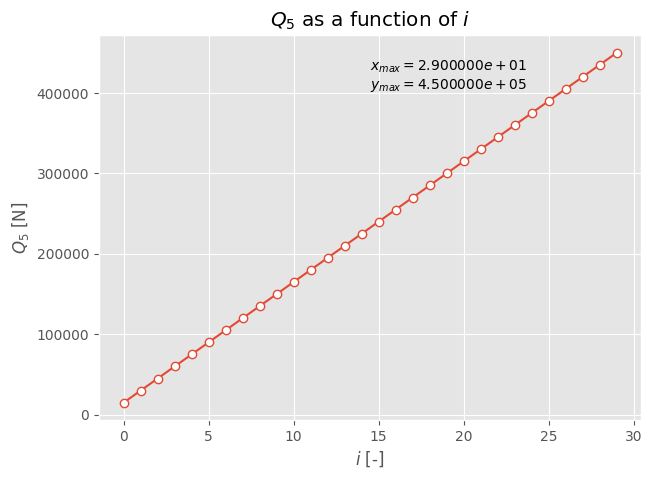

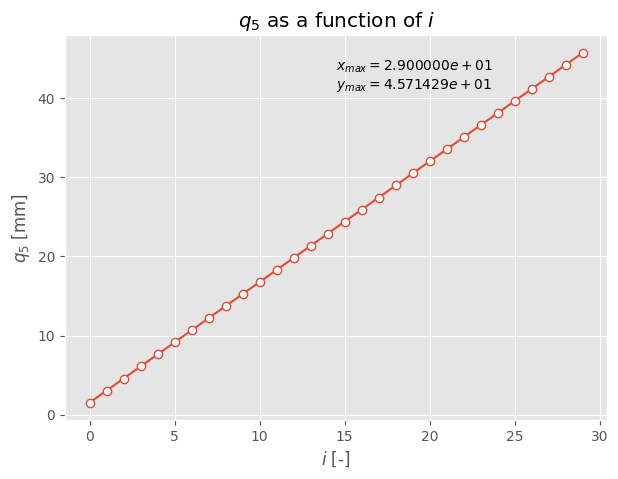

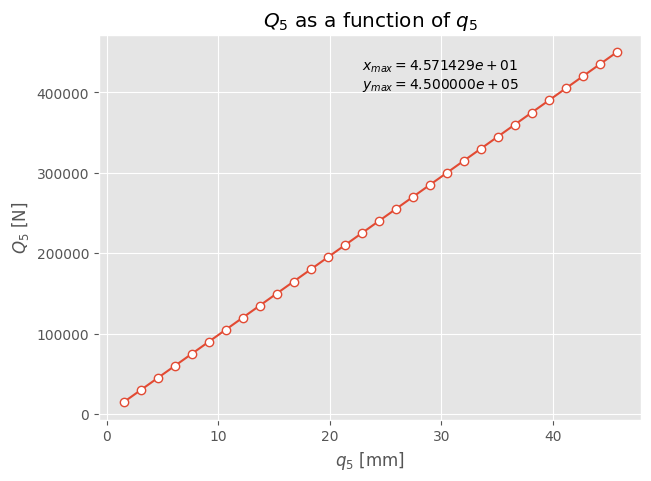

In [19]:
printgraph(iteration_counter,force5,"$i$","$Q_5$","","N")
printgraph(iteration_counter,disp5,"$i$","$q_5$","","mm")
printgraph(disp5,force5,"$q_5$","$Q_5$","mm","N")
 

Step 3: Plasticity: Add an elastic-perfectly-plastic (EPP) material

In [28]:
sigma_y=355 #MPa
Ep=200000*np.ones((len(r), nf)) #MPa

In [39]:
#stress function

def stress_elastic_perfectly_plastic(E,Ep, sigma_y,eps):
    eps_y=sigma_y/E
    sigma=np.zeros((len(r), nf))

    for j in range(len(r)):
        for i in range(nf):
            if np.abs(eps[j,i])<eps_y:
                Ep[j,i]=Ep[j,i]
                E=E
                sigma[j,i]=E*eps[j,i]
            else:
                sigma[j,i]=np.sign(eps[j,i])*sigma_y
                E=0
                Ep[j,i]=0
    
    return sigma, Ep

In [41]:
#stress and tangent modulus for each fiber, at each integration point

stress_EPP,E_EPP=stress_elastic_perfectly_plastic(E, Ep, sigma_y,strain)
print(f"{stress_EPP=}")
print(f"{Ep = }")

stress_EPP=array([[-355., -355.,   -0.,   -0.,    0.,    0.,  355.,  355.],
       [-355., -355.,   -0.,   -0.,    0.,    0.,  355.,  355.],
       [  -0.,   -0.,   -0.,   -0.,    0.,    0.,    0.,    0.],
       [  -0.,   -0.,   -0.,   -0.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,    0.,   -0.,   -0.,   -0.,   -0.]])
Ep = array([[     0.,      0., 200000., 200000., 200000., 200000.,      0.,      0.],
       [     0.,      0., 200000., 200000., 200000., 200000.,      0.,      0.],
       [200000., 200000., 200000., 200000., 200000., 200000., 200000., 200000.],
       [200000., 200000., 200000., 200000., 200000., 200000., 200000., 200000.],
       [200000., 200000., 200000., 200000., 200000., 200000., 200000., 200000.]])


In [ ]:
#newton raphson step 3

